# Importing Libraries and Data

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# nltk
import nltk
import nltk.corpus
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk import NaiveBayesClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# wordcloud
from wordcloud import WordCloud

# sklearn
import sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
encoding = "ISO-8859-1"
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Predictive Analytics Course/Final Project/Apple-Twitter-Sentiment-DFE.csv', encoding = encoding)

# EDA

In [6]:
data.head()

/usr/local/lib/python3.10/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,12/12/14 12:14,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,5.400000e+17,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [7]:
data['sentiment'].value_counts()

#Show the unique values and their counts for 'sentiment'

sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64

In [8]:
# How many reviews we have
print('There are', data.shape[0], 'reviews')

# Check for duplicates
print("There are", len(data[data.duplicated()]), "duplicates")

# Check if we have missing values. Every review has at least one missing value, but it doesn't matter to the analysis.
print("There are", data.isnull().sum().sum(), "missing values")

There are 3886 reviews
There are 0 duplicates
There are 3886 missing values


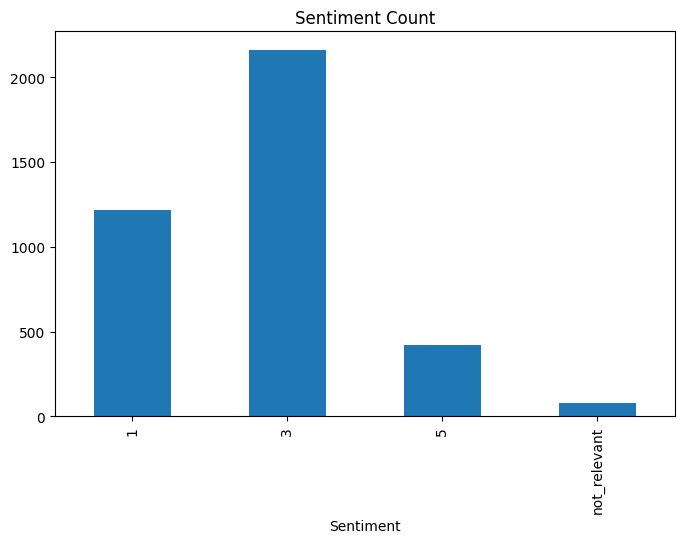

In [9]:
ax = data.sentiment.value_counts().sort_index().plot(kind='bar', title='Sentiment Count', figsize=(8, 5))
ax.set_xlabel('Sentiment')
plt.show()

#Chart showing distribution of sentiment

In [10]:
data = data[data['sentiment'] != 'not_relevant']
data['sentiment'].unique()

#Removed rows with 'not_relevant' in the 'sentiment' column.

array(['3', '5', '1'], dtype=object)

# Feature Extraction

In [11]:
#Only need text and sentiment columns for NLP

data = data[['sentiment', 'text']]
data.head(10)

,sentiment,text
0,3,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,3,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,3,My cat only chews @apple cords. Such an #Apple...
3,3,I agree with @jimcramer that the #IndividualIn...
4,3,Nobody expects the Spanish Inquisition #AAPL
5,3,#AAPL:5 Rocket Stocks to Buy for December Gain...
6,5,Top 3 all @Apple #tablets. Damn right! http://...
7,5,CNBCTV: #Apple's margins better than expected?...
8,3,Apple Inc. Flash Crash: What You Need to Know ...
9,3,#AAPL:This Presentation Shows What Makes The W...


In [12]:
# create lemmatizer
lemmatizer = WordNetLemmatizer()

In [13]:
# function to get the simpler version of pos tag  to use  in lemmitazation
def get_simple_pos(tag):
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [32]:
def preprocess(textdata):

    # Handle potential non-string texts
    if not isinstance(textdata, str):
        return ""  # Or any suitable default value for non-string texts

    clean_words=[]

    # Remove email addresses patterns
    raw_text = re.sub('\b[\w\-.]+?@\w+?\w+?\.\w{2,4}\b'," ", textdata)
    # Remove URLs  patterns
    raw_text =re.sub("[^a-zA-Z]"," ", raw_text)
    # Remove numbers
    raw_text= re.sub("\d+(\.\d+)?"," ", raw_text)
    # Replace @USERNAME to 'USER'
    raw_text = re.sub('@[^\s]+', 'USER', raw_text)
    # Replace appl abbreviation with apple
    raw_text = re.sub('aapl', 'apple', raw_text)
    # Replace rt (retweet) with blank
    raw_text = re.sub('rt', ' ', raw_text)

    stop_words=set(stopwords.words("english"))
    words_tokens= nltk.word_tokenize(raw_text)
    for word in words_tokens :

      if word.lower() not in stop_words:
        pos = pos_tag([word]) # get the part of speech of each word

        # Use a list comprehension to get the lemmatized word
        clean_word=[lemmatizer.lemmatize(word.lower(), pos=get_simple_pos(tag)) for word, tag in pos]
        clean_words.append("".join(clean_word))

    #processed_texts.append(raw_text)

    #return processed_texts

    return (" ".join(clean_words))

In [33]:
clean_text_corpus = []

for index, row in data.iterrows():
    clean_text_corpus.append(preprocess(row["text"]))

    #clean_text_corpus

In [34]:
data["text"] = data["text"].apply(preprocess)
data["text"].head()

0      apple best steve job email ever http co g kl tx
1    jpdesloges apple stock mini flash crash today ...
2                        cat chew apple cord applesnob
3    agree jimcramer individualinvestor trade apple...
4              nobody expect spanish inquisition apple
Name: text, dtype: object

In [35]:
data.head(10)

,sentiment,text
0,3,apple best steve job email ever http co g kl tx
1,3,jpdesloges apple stock mini flash crash today ...
2,3,cat chew apple cord applesnob
3,3,agree jimcramer individualinvestor trade apple...
4,3,nobody expect spanish inquisition apple
5,3,apple rocket stock buy december gain apple htt...
6,5,top apple tablet damn right http co rjign juub
7,5,cnbctv apple margin well expect apple http co ...
8,3,apple inc flash crash need know http co yjigti...
9,3,apple presentation show make world biggest tec...


In [36]:
words_values = pd.Series(" ".join(data["text"]).split()).value_counts()
print(words_values)
rare_words = words_values[words_values <= 3]
print(rare_words)
print(rare_words.value_counts())

apple                 5261
co                    2275
http                  2264
iphone                 500
need                   433
                      ... 
fcocuengin               1
onthisdayindigital       1
central                  1
isheep                   1
bicru                    1
Name: count, Length: 7664, dtype: int64
lp                    3
shopping              3
govt                  3
classroom             3
bull                  3
                     ..
fcocuengin            1
onthisdayindigital    1
central               1
isheep                1
bicru                 1
Name: count, Length: 6244, dtype: int64
count
1    4776
2    1032
3     436
Name: count, dtype: int64


# Test, Train, Split

In [19]:
# Assuming 'data' is your DataFrame containing 'text' and 'sentiment' columns
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['sentiment'], test_size=0.05, random_state=0)

# Verify the shapes of the resulting splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3613,) (191,) (3613,) (191,)


In [20]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features = 500000)
vectorizer.fit(X_train)

# Creating vectorizer to transform text into matrix

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [21]:
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

# Applying vectorizer to X_train and X_test

In [22]:
def model_evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

# Creating a function to evaluate different models

In [23]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_evaluate(LRmodel)

# Defining Logistic Regression model and evaluating

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


              precision    recall  f1-score   support

           1       0.77      0.67      0.72        51
           3       0.77      0.92      0.84       117
           5       0.86      0.26      0.40        23

    accuracy                           0.77       191
   macro avg       0.80      0.62      0.65       191
weighted avg       0.78      0.77      0.75       191



In [24]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_evaluate(SVCmodel)

#Defining LinearSVC model and evaluating

              precision    recall  f1-score   support

           1       0.76      0.69      0.72        51
           3       0.77      0.89      0.83       117
           5       0.60      0.26      0.36        23

    accuracy                           0.76       191
   macro avg       0.71      0.61      0.64       191
weighted avg       0.75      0.76      0.74       191



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [25]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_evaluate(BNBmodel)

# Defining BernoulliNB model and evaluating

              precision    recall  f1-score   support

           1       1.00      0.12      0.21        51
           3       0.63      1.00      0.77       117
           5       0.00      0.00      0.00        23

    accuracy                           0.64       191
   macro avg       0.54      0.37      0.33       191
weighted avg       0.65      0.64      0.53       191



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predictions

In [28]:
def predict(model, text):
    # Predict the sentiment
    if isinstance(text, str):
        text = [text]
    # Apply preprocess to the text and create variable preprocessed_text
    preprocessed_text = [preprocess(t) for t in text]

    # Transform preprocessed_text into a vector.
    preprocessed_text = vectorizer.transform(preprocessed_text)

    # Apply models to preprocessed text
    predictions = model.predict(preprocessed_text)

    # Creating labels for each prediction output
    pred_to_label = {'1': 'Negative', '3': 'Neutral', '5': 'Positive'}

    # Make a list of text with sentiment.
    data = []
    for t, pred in zip(text, predictions):
            data.append((pred, pred_to_label[pred]))

    return data

# Defining the predict function.

In [53]:
new_text = ['I love all my apple products! I plan on buying many more in the future.']
#new_text = ['Apple computers are okay, but Linux is better.']
#new_text = ["Apple sucks. I'm never buying a mac or iphone again."]

In [45]:
models = [LRmodel, SVCmodel, BNBmodel]

# Creating a list of all models

In [54]:
for model in models:
    prediction = predict(model, new_text)
    print(f'The model {model} predicts a prediction of {prediction}')

# Predicting the sentiment of each new tweet with all models
# BernoulliNB seems to be less accurate in testing

The model LogisticRegression(C=2, max_iter=1000, n_jobs=-1) predicts a prediction of [('5', 'Positive')]
The model LinearSVC() predicts a prediction of [('5', 'Positive')]
The model BernoulliNB(alpha=2) predicts a prediction of [('3', 'Neutral')]
